In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from collections import Counter
from scipy.stats import loguniform
import scipy
import pickle as pkl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/uoh_Project/train.csv')
X=data.drop(['ID', 'TARGET'], axis=1)
y=data.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

Test Data to be submitted in Kaggle

In [15]:
test_data = pd.read_csv('/content/drive/MyDrive/uoh_Project/test.csv')
X_test_final = test_data.drop(['ID'], axis=1)

## Filter Features

In [ ]:
def get_constant_columns(data):
    # loop over all columns and use nunique() method in pandas to get different values of a feature
    # check if these values of a feature equal to 1
    constant_features = [feature for feature in data.columns if data[feature].nunique() == 1]
    return constant_features

def get_quasi_constant_columns(data,threshold):
    # an empty list for quasi constant feature
    quasi_constant_feat = []
    # iterate over every feature in train data
    for feature in data.columns:
        # find the predominant value, common in most data
        predominant = (data[feature].value_counts() / len(data)).sort_values(ascending=False).values[0]
        # evaluate the predominant feature: do more than threshold of the observations
        # show 1 value?
        if predominant > (threshold/100):
            # if yes, add the variable to the list
            quasi_constant_feat.append(feature)
    return(quasi_constant_feat)

def get_duplicate_columns(data):
    # create an empty dictionary, where we will store 
    # the groups of duplicates
    duplicated_feat_pairs = {}

    # create an empty list to collect features
    # that were found to be duplicated
    _duplicated_feat = []

    # iterate over every feature in our dataset:
    for i in range(0, len(data.columns)):
        # pick 1 feature
        feat_1 = data.columns[i]
        # check if this feature is already identified as duplicate feature or not
        # if not we can proceed further
        if feat_1 not in _duplicated_feat:
            # create an empty list as an entry for this feature in the dictionary:
            duplicated_feat_pairs[feat_1] = []
            # now, iterate over the remaining features of the dataset:
            for feat_2 in data.columns[i + 1:]:
                # check if this second feature is identical to the first one
                if data[feat_1].equals(data[feat_2]):
                    # if it is identical, append it to the list in the dictionary
                    duplicated_feat_pairs[feat_1].append(feat_2)
                    # and append it to our monitor list for duplicated variables
                    _duplicated_feat.append(feat_2)
    return _duplicated_feat

def get_filtered_columns(data,threshold):
    # first call function to get all constant features
    constantFeatures = get_constant_columns(data)
    # remove the constant features from data to avoid overlap in columns
    new_data = data.drop(constantFeatures,axis=1)
    
    # next call function to get all quasi constant features 
    quasiConstantFeatures = get_quasi_constant_columns(new_data,threshold)
    # remove the quasi constant features from data to avoid overlap in columns
    new_data = new_data.drop(quasiConstantFeatures, axis=1)
    
    # next call function to get all duplicate features
    duplicateFeatures = get_duplicate_columns(new_data)
    
    return (constantFeatures, quasiConstantFeatures, duplicateFeatures)

In [ ]:
constantFeatures, quasiConstantFeatures, duplicateFeatures = get_filtered_columns(X_train,99)

In [ ]:
finalFilteredColumns=[]
finalFilteredColumns.extend(constantFeatures)
finalFilteredColumns.extend(quasiConstantFeatures)
finalFilteredColumns.extend(duplicateFeatures)

In [ ]:
tableData=[['Constant Feature', len(constantFeatures)],
           ['Quasi Constant Features', len(quasiConstantFeatures)],
           ['Duplicate Features', len(duplicateFeatures)],
           ['-----------------------','-----------------'],
           ['TOTAL', len(finalFilteredColumns)]]
print(tabulate(tableData, headers=['Filtering Method','Features Filtered'], tablefmt="pretty"))

+-------------------------+-------------------+
|    Filtering Method     | Features Filtered |
+-------------------------+-------------------+
|    Constant Feature     |        47         |
| Quasi Constant Features |        171        |
|   Duplicate Features    |         6         |
| ----------------------- | ----------------- |
|          TOTAL          |        224        |
+-------------------------+-------------------+


In [ ]:
print(X_train.shape) # --> shape before filtering 
X_train=X_train.drop(finalFilteredColumns,axis=1)
print(X_train.shape) # --> shape after filtering 

(60816, 369)
(60816, 145)


In [ ]:
# For Test Data 
print(X_test.shape) # --> shape before filtering 
X_test=X_test.drop(finalFilteredColumns,axis=1)
print(X_test.shape) # --> shape after filtering 

(15204, 369)
(15204, 145)


In [ ]:
# For Test Data Final
print(X_test_final.shape) # --> shape before filtering 
X_test_final=X_test_final.drop(finalFilteredColumns,axis=1)
print(X_test_final.shape) # --> shape after filtering 

(75818, 369)
(75818, 145)


## Remove Correlated Features Smartly

In [ ]:
def create_correlated_df(data):    
    corr_matrix = data.corr().abs().unstack().sort_values(ascending=False)
    corr_matrix = pd.DataFrame(corr_matrix).reset_index()
    corr_matrix.columns = ['feature1', 'feature2', 'corr']
    # matrix contains feature pairs which are correlated more than 0.95
    corr_matrix = corr_matrix[(corr_matrix['corr'] < 1) & (corr_matrix['corr'] >= 0.95)]
    return corr_matrix

def find_correlated_groups(matrix):
    
    # find groups of correlated features

    grouped_feature_ls = []
    correlated_groups = []

    for feature in matrix.feature1.unique():

        if feature not in grouped_feature_ls:

            # find all features correlated to a single feature
            correlated_block = matrix[matrix.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]

            # append the block of features to the list
            correlated_groups.append(correlated_block)
    
    return correlated_groups

def smart_correlation(data,target):
    # get a correlated dataframe of each feature pair
    corr_mat = create_correlated_df(data)
    
    # next we find features which are correlated 
    correlated_features_groups = find_correlated_groups(corr_mat)
    
    features_with_high_corr = []
    # loop over each correlated groups that we have aquired
    for i in range(len(correlated_features_groups)):
        corr_group = correlated_features_groups[i]
        # get all features from feature1 col and feature2 col
        features = list(corr_group['feature2'].unique())+list(corr_group['feature1'].unique())
        # build a Pipeline with SMOTE and random forest classifier
        rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
        # SMOTE help oversample the data with creating synthetic points for minority class, 
        # rather than normal oversampling, which just copies the minority class data points again
        steps = [('oversampling', SMOTE()), ('model', rf)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(data[features],target)
        # get feature importance of all the features in the correlated group
        importance = pd.concat([pd.Series(features),
                                pd.Series(rf.feature_importances_)],
                               axis=1)
        importance.columns = ['feature', 'importance']
        # sort features by importance, most important first
        importance=importance.sort_values(by='importance', ascending=False)
        # remove the most important feature from the list of features in that group
        features.remove(importance.feature[0])
        # append the remaining features as features to be removed
        features_with_high_corr.extend(features)

    return list(set(features_with_high_corr))

In [ ]:
features_with_high_corr = smart_correlation(X_train,y_train)

In [ ]:
print(X_train.shape) # --> shape before removing correlated features 
X_train = X_train.drop(features_with_high_corr,axis=1)
print(X_train.shape) # --> shape after removing correlated features 

(60816, 145)
(60816, 96)


In [ ]:
# For test data
print(X_test.shape) # --> shape before removing correlated features 
X_test = X_test.drop(features_with_high_corr,axis=1)
print(X_test.shape) # --> shape after removing correlated features 

(15204, 145)
(15204, 96)


In [ ]:
# For test data final
print(X_test_final.shape) # --> shape before removing correlated features 
X_test_final = X_test_final.drop(features_with_high_corr,axis=1)
print(X_test_final.shape) # --> shape after removing correlated features 

(75818, 145)
(75818, 96)


## Do Feature Engineering and Log transformation and Reduce Cardinality 

In [ ]:
def kmeanFeat(data):
    clusterSizes = list(np.arange(2,21))
    cols=data.columns
    # Standardize the data
    sc=StandardScaler()
    dataCopy=data.copy()
    dataCopy.loc[:,cols]= sc.fit_transform(dataCopy.loc[:,cols])
    Sum_of_squared_distances = []
    for num_clusters in clusterSizes:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(data)
        Sum_of_squared_distances.append(kmeans.inertia_)
    plt.plot(clusterSizes,Sum_of_squared_distances,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

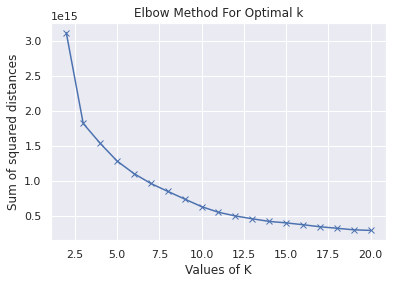

In [ ]:
new_train = X_train.copy()
kmeanFeat(new_train)

Seems that optimal K is 11 , because after that there is not much drop in distance.

In [ ]:
def kmeanFeat(tr_data, test_data, test_data_final):
    clusterSizes = list(np.arange(2,12))
    cols=tr_data.columns
    # Standardize the data
    sc=StandardScaler()
    # copy the data
    tr_data_copy=tr_data.copy()
    test_data_copy=test_data.copy()
    test_data_final_copy=test_data_final.copy()
    # fit the data on training data
    tr_data_copy.loc[:,cols]= sc.fit_transform(tr_data_copy.loc[:,cols])
    # transform the test and final test data
    test_data_copy.loc[:,cols]= sc.transform(test_data_copy.loc[:,cols])
    test_data_final_copy.loc[:,cols]= sc.transform(test_data_final_copy.loc[:,cols])

    for size in clusterSizes:
        f_name='K-mean-cluster-'+str(size)
        kmeans = KMeans(n_clusters=size,random_state=42)
        
        # create a new feature for each cluster size
        tr_data[f_name] = kmeans.fit_predict(tr_data_copy)
        test_data[f_name] = kmeans.predict(test_data_copy)
        test_data_final[f_name] = kmeans.predict(test_data_final_copy)

    return (tr_data, test_data, test_data_final)

In [ ]:
X_train, X_test, X_test_final = kmeanFeat(X_train.copy(), X_test.copy(), X_test_final.copy())

In [ ]:
def feature_engineering(data):
    # add a new feature to store count number of zeroes across a row
    data['count_zeroes'] = (data == 0).astype(int).sum(axis=1)
    
    # add a new feature to store count number of non zeroes across a rows
    data['count_non_zeroes'] = (data != 0).astype(int).sum(axis=1)
    
    # add a new feature to store if var3 value is mode (most common nationality)
    data['var3_mode'] = [1 if i==2 else 0 for i in data.var3]
    
    # replace -999999 outlier in var3 by mode value
    data.var3 = data.var3.replace(to_replace=-999999, value=2)
    
    # add a new feature to capture customers with var15 below 23
    data['var15_below_23'] = [1 if i<23 else 0 for i in data.var15]
    
    # add a new feature to store the insights for var36 that the value was 99 (outlier)
    data['var36_is_99'] = [1 if i==99 else 0 for i in data.var36]
    
    # replace this 99 in var36 with the value 2 as calculated through KNNImputer
    data.var36 = data.var36.replace(to_replace=99, value=2)
    
    # add a new feature to capture the mode value for var38
    data['var38_mode'] = [1 if i==117310.979016494 else 0 for i in data.var38]
    
    # add a new feature to capture is saldo_medio_var5_ult3 is 0 or not
    data['sal_medio_var5_ult3_is_0'] = [1 if i==0.0 else 0 for i in data.saldo_medio_var5_ult3]
    
    # add a new feature to capture if saldo_var30 is 0 or 3 or something else
    data['sal_var30_is_0_3'] = [1 if i in [0,3] else 0 for i in data.saldo_var30]
    
    # for 'num' keyword features we saw that there was pattern of divisible by 3
    # hence we take sum of those features which are non-zero and divisble by 3 across each row
    numKeywordFeatures = [column for column in data.columns if 'num' in column]
    data['Feat_divisible_by_3']=((data[numKeywordFeatures]%3==0) & (data[numKeywordFeatures]!=0)).astype(int).sum(axis=1)
    
    return data

def get_log_on_data(data):
    # while EDA it was evident to take log on var38 to better Gaussian like distribution
    data['var38_log'] = np.log(data.var38)
    data = data.drop(['var38'], axis=1)
    
    # for features with keyword 'imp' we decided to use the log of the values
    impKeywordFeatures = [column for column in data.columns if 'imp' in column]
    for feat in impKeywordFeatures:
        new_feat = feat + '_log'
        data[new_feat] = [val if val <= 0 else np.log(val) for val in data[feat]]
    data = data.drop(impKeywordFeatures, axis=1)
    
    # for features with keyword 'saldo' we decided to use the log of the values
    saldoKeywordFeatures = [column for column in data.columns if 'saldo' in column]
    for feat in saldoKeywordFeatures:
        new_feat = feat+'_log'
        data[new_feat] = [val if val <= 0 else np.log(val) for val in data[feat]]
    data = data.drop(saldoKeywordFeatures, axis=1)
    
    return data

In [ ]:
X_train1 = feature_engineering(X_train.copy())
X_test1 = feature_engineering(X_test.copy())
X_test_final1 = feature_engineering(X_test_final.copy())

print(X_train1.shape)
print(X_test1.shape)
print(X_test_final1.shape)

(60816, 115)
(15204, 115)
(75818, 115)


In [ ]:
X_train1 = get_log_on_data(X_train1)
X_test1 = get_log_on_data(X_test1)
X_test_final1 = get_log_on_data(X_test_final1)

### 1. Data set one Response Encoded Categorical Variables

In [ ]:
def categoricalFeatures(data):
    # create empty list to store features which needs to be encoded
    features_to_encode=[] 

    # loop over all columns of data to find the columns which satisfy below condition
    for col in data.columns:
        if (data[col].nunique()<=10) & (data[col].nunique()>2) & ('K-mean' not in col):
            features_to_encode.append(col)

    # return the feature list
    return features_to_encode


def response_encoding(X_train, X_test, X_test_final, y_train, feature_name):
    data_temp = X_train.join(y_train)
    feature_1 = feature_name + '_1'
    feature_0 = feature_name + '_0'

    # get unique values for this feature from train data
    unique_values = set(data_temp[feature_name].values)

    # use dictionary to store response encoding with respect to TARGET
    dict_values_1 = {}
    dict_values_0 = {}

    # Categories that are not seen in train will be assigned equal score (0.5 in our case as we have only 2 TARGET)
    dict_values_1['missing'] = 0.5 
    dict_values_0['missing'] = 0.5

    # loop over all unique values from train data
    for value in unique_values:
        # total num. of datapoints with 'value' catgeory
        total = len(data_temp[data_temp[feature_name]==value])

        # total num. of datapoints with category being 'value' and target == 1
        sum_tot_val_1 = len(data_temp[ (data_temp[feature_name]==value) & (data_temp['TARGET']==1) ])
        # total num. of datapoints with category being 'value' and target == 0
        sum_tot_val_0 = len(data_temp[ (data_temp[feature_name]==value) & (data_temp['TARGET']==0) ])
        
        # Calc. the probabilty score of that value seen in each class and store in dictionary
        dict_values_1[value] = np.round( (sum_tot_val_1/total) ,5 )
        dict_values_0[value] = np.round( (sum_tot_val_0/total) ,5 )

    X_train[feature_1] = (X_train[feature_name].map(dict_values_1)).values
    X_train[feature_0] = (X_train[feature_name].map(dict_values_0)).values

    X_train.drop(feature_name,axis=1,inplace=True)

    # get unique values of the column from test data
    unique_values_test = set(X_test[feature_name].values)

    # replace all values which are present in missing from train
    X_test[feature_name] = X_test[feature_name].apply(lambda x: 'missing' if x in (unique_values_test-unique_values) else x )

    X_test[feature_1] = (X_test[feature_name].map(dict_values_1)).values
    X_test[feature_0] = (X_test[feature_name].map(dict_values_0)).values

    X_test.drop(feature_name,axis=1,inplace=True)

    # get unique values of the column from test  final data
    unique_values_test_final = set(X_test_final[feature_name].values)

    # replace all values which are present in missing from train
    X_test_final[feature_name] = X_test_final[feature_name].apply(lambda x: 'missing' if x in (unique_values_test_final-unique_values) else x )

    X_test_final[feature_1] = (X_test_final[feature_name].map(dict_values_1)).values
    X_test_final[feature_0] = (X_test_final[feature_name].map(dict_values_0)).values

    X_test_final.drop(feature_name,axis=1,inplace=True)

In [ ]:
# get which features to response encode
features_to_encode = categoricalFeatures(X_train1)

X_train1_re = X_train1.copy()
X_test1_re = X_test1.copy()
X_test1_final_re = X_test_final1.copy()

# response encode the data
for feat in features_to_encode:
    response_encoding(X_train1_re, X_test1_re, X_test1_final_re, y_train, feat)

print(X_train1_re.shape)
print(X_test1_re.shape)
print(X_test1_final_re.shape)

(60816, 134)
(15204, 134)
(75818, 134)


In [ ]:
def cumulatively_categorise(column,threshold=0.90,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: str(x) if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
    else:
        #Return only the transformed column if return_categories=False
        return new_column
    
def reduceCardinality(data):
    # get all features with 'num' keyword in its name
    numKeywordFeatures = [i for i in data.columns if 'num' in i ]
    
    featCardinalitydict = {}
    for feat in numKeywordFeatures:
        transformed_column, new_category_list=cumulatively_categorise(data[feat],return_categories_list=True)
        featCardinalitydict[feat] = new_category_list
        data[feat] = transformed_column
        
    for feat in featCardinalitydict.keys():
        data[feat] = data[feat].astype(str)
        
    return data, featCardinalitydict

In [ ]:
# 1. After feature engineering we have this dataset 'X_train1'
X_train1 = feature_engineering(X_train.copy())

# 2. Then I try to reduce the cardinality for 'num' keywords feature 
X_train2, featCardinalitydict = reduceCardinality(X_train1.copy())

# 3. Now I take log on specific dataset to create a all new dataset 'newData_redCardwithLog'
X_train3 = get_log_on_data(X_train2.copy())

In [ ]:
def reduceCardForTest(data,featCardinalitydict):
    for feat in featCardinalitydict.keys():
        data[feat] = [val if val in featCardinalitydict[feat] else 'Other' for val in data[feat]]
        data[feat] = data[feat].astype(str)
    return data

In [ ]:
# 1. After feature engineering we have this dataset 'X_test1'
X_test1 = feature_engineering(X_test.copy())

# 2. Then I try to reduce the cardinality for 'num' keywords feature
X_test2 = reduceCardForTest(X_test1.copy(), featCardinalitydict)

# 3. Now I take log on specific dataset to create a all new dataset 'newData_redCardwithLog'
X_test3 = get_log_on_data(X_test2.copy())

In [ ]:
# 1. After feature engineering we have this dataset 'X_final_test1'
X_test_final1 = feature_engineering(X_test_final.copy())

# 2. Then I try to reduce the cardinality for 'num' keywords feature
X_test_final2 = reduceCardForTest(X_test_final1.copy(), featCardinalitydict)

# 3. Now I take log on specific dataset to create a all new dataset 'newData_redCardwithLog'
X_test_final3 = get_log_on_data(X_test_final2.copy())

## One hot encoding

In [ ]:
def oneHotEncoding(train,test,testf):
    ## get those features which have unique value less than 16 to encode and greater than 1
    features_to_encode = []
    for col in train.columns:
        if (train[col].nunique()<=15) & (train[col].nunique()>=2) & ('K-mean' not in col):
            features_to_encode.append(col)

    for feat in features_to_encode:
        dataTemp = pd.get_dummies(train[feat], prefix=feat, drop_first=True)
        train = pd.concat([train, dataTemp], axis=1)
    
    # next we remove the features that are now one hot encoded
    for i in features_to_encode:
        train.drop(i,axis=1,inplace=True)

    for feat in features_to_encode:
        dataTemp = pd.get_dummies(test[feat], prefix=feat, drop_first=True)
        test = pd.concat([test, dataTemp], axis=1)
        
    for feat in features_to_encode:
        dataTemp = pd.get_dummies(testf[feat], prefix=feat, drop_first=True)
        testf = pd.concat([testf, dataTemp], axis=1)
    
    # next we remove the features that are now one hot encoded
    for i in features_to_encode:
        test.drop(i,axis=1,inplace=True)
        
    for i in features_to_encode:
        testf.drop(i,axis=1,inplace=True)
        
    return train,test,testf

In [ ]:
def one_hot_encoding(train,test,test_final):
    """
    one hot encodes all the features in col array in all X dataset
    """
    features_to_encode = []
    for col in train.columns:
        if (train[col].nunique()<=10) & (train[col].nunique()>=2) & ('K-mean' not in col):
            features_to_encode.append(col)
    
    ohe = OneHotEncoder(sparse=True,handle_unknown='ignore')
    ohe.fit(train.loc[:,features_to_encode])
    feature_names = list(ohe.get_feature_names(input_features=features_to_encode))
    features = list(train.drop(features_to_encode,axis=1).columns)
    features.extend(feature_names)

    #train
    
    df = train.copy()
    temp = ohe.transform(df[features_to_encode])
    df.drop(features_to_encode,axis=1,inplace=True)
    train = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()
    train = train.loc[:,~train.columns.duplicated(keep='first')] #removing duplicated columns (duplicated columsn were seen)


    #test
    df = test.copy()
    temp = ohe.transform(df[features_to_encode])
    df.drop(features_to_encode,axis=1,inplace=True)
    test = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()
    test = test.loc[:,~test.columns.duplicated(keep='first')] #removing duplicated columns (duplicated columsn were seen)
    
    #test_final
    df = test_final.copy()
    temp = ohe.transform(df[features_to_encode])
    df.drop(features_to_encode,axis=1,inplace=True)
    testf = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()
    testf = testf.loc[:,~testf.columns.duplicated(keep='first')] #removing duplicated columns (duplicated columsn were seen)

    return train,test,testf

In [ ]:
X_train1_ohe,X_test1_ohe,X_test1_final_ohe = one_hot_encoding(X_train1.copy(),X_test1.copy(),X_test_final1.copy())
X_train2_ohe,X_test2_ohe,X_test2_final_ohe = oneHotEncoding(X_train2.copy(),X_test2.copy(),X_test_final2.copy())
X_train3_ohe,X_test3_ohe,X_test3_final_ohe = oneHotEncoding(X_train3.copy(),X_test3.copy(),X_test_final3.copy())

In [ ]:
print(X_train1_ohe.shape)
print(X_train2_ohe.shape)
print(X_train3_ohe.shape)
print(X_test1_ohe.shape)
print(X_test2_ohe.shape)
print(X_test3_ohe.shape)
print(X_test1_final_ohe.shape)
print(X_test2_final_ohe.shape)
print(X_test3_final_ohe.shape)

(60816, 231)
(60816, 165)
(60816, 165)
(15204, 231)
(15204, 165)
(15204, 165)
(75818, 231)
(75818, 165)
(75818, 165)


## Save the Training and Test data till here

In [ ]:
# dataset 1
X_train1_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_train1_ohe.pkl")
X_train2_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_train2_ohe.pkl")
X_train3_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_train3_ohe.pkl")
# dataset 2
X_test1_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test1_ohe.pkl")
X_test2_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test2_ohe.pkl")
X_test3_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test3_ohe.pkl")
# dataset 3
X_test1_final_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test1_final_ohe.pkl")
X_test2_final_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test2_final_ohe.pkl")
X_test3_final_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test3_final_ohe.pkl")
# dataset 4
X_train1_re.to_pickle("/content/drive/MyDrive/uoh_Project/X_train1_re.pkl")
X_test1_re.to_pickle("/content/drive/MyDrive/uoh_Project/X_test1_re.pkl")
X_test1_final_re.to_pickle("/content/drive/MyDrive/uoh_Project/X_test1_final_re.pkl")

In [33]:
# dataset 1
X_train1_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train1_ohe.pkl")
X_train2_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train2_ohe.pkl")
X_train3_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train3_ohe.pkl")
# dataset 2
X_test1_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test1_ohe.pkl")
X_test2_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test2_ohe.pkl")
X_test3_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test3_ohe.pkl")
# dataset 3
X_test1_final_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test1_final_ohe.pkl")
X_test2_final_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test2_final_ohe.pkl")
X_test3_final_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test3_final_ohe.pkl")
# dataset 4
X_train1_re = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train1_re.pkl")
X_test1_re = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test1_re.pkl")
X_test1_final_re = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test1_final_re.pkl")

In [5]:
y_train.to_pickle("/content/drive/MyDrive/uoh_Project/y_train.pkl")
y_test.to_pickle("/content/drive/MyDrive/uoh_Project/y_test.pkl")

In [6]:
y_train = pd.read_pickle("/content/drive/MyDrive/uoh_Project/y_train.pkl")
y_test = pd.read_pickle("/content/drive/MyDrive/uoh_Project/y_test.pkl")

## Standardize the data

In [8]:
sc=StandardScaler()
sc.fit(X_train1_ohe)
X_train1_ohe = sc.transform(X_train1_ohe)
X_test1_ohe = sc.transform(X_test1_ohe)
X_test1_final_ohe = sc.transform(X_test1_final_ohe)
print(X_train1_ohe.shape)
print(X_test1_ohe.shape)
print(X_test1_final_ohe.shape)

(60816, 231)
(15204, 231)
(75818, 231)


In [9]:
sc=StandardScaler()
sc.fit(X_train2_ohe)
X_train2_ohe = sc.transform(X_train2_ohe)
X_test2_ohe = sc.transform(X_test2_ohe)
X_test2_final_ohe = sc.transform(X_test2_final_ohe)
print(X_train2_ohe.shape)
print(X_test2_ohe.shape)
print(X_test2_final_ohe.shape)

(60816, 165)
(15204, 165)
(75818, 165)


In [10]:
sc=StandardScaler()
sc.fit(X_train3_ohe)
X_train3_ohe = sc.transform(X_train3_ohe)
X_test3_ohe = sc.transform(X_test3_ohe)
X_test3_final_ohe = sc.transform(X_test3_final_ohe)
print(X_train3_ohe.shape)
print(X_test3_ohe.shape)
print(X_test3_final_ohe.shape)

(60816, 165)
(15204, 165)
(75818, 165)


In [11]:
sc=StandardScaler()
sc.fit(X_train1_re)
X_train1_re = sc.transform(X_train1_re)
X_test1_re = sc.transform(X_test1_re)
X_test1_final_re = sc.transform(X_test1_final_re)
print(X_train1_re.shape)
print(X_test1_re.shape)
print(X_test1_final_re.shape)

(60816, 134)
(15204, 134)
(75818, 134)


## Modelling

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from numpy import mean
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV  ## as linear classifier dont have predict proba using the calibratedclassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from xgboost import XGBRFClassifier

In [12]:
def plotConfusionM(X_train, X_test, y_train, y_test, model):
   
    # getting the predicted probabilty of training and test dataset
    y_train_pred = model.predict_proba(X_train) [:,1]
    y_test_pred = model.predict_proba(X_test) [:,1]

    # Plot the ROC curve for train and test dataset
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    #test_auc = auc(test_fpr, test_tpr)  
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Plot")
    plt.grid()
    plt.show()

     # finding the best value of threshold using this function
    print("="*74)
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print("="*74)
    
    # Creating subplots to show Train and Test Confusion Matrix along with 
    # Box Plot (of Price for FP points in Test Data) and PDF (of Number of Previously posted Project for FP points in Test Data)
    plt.figure(figsize=[12,10])
    plt.tight_layout()
    plt.subplot(2, 2, 1) 
    plt.title("Train confusion matrix")
    sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot = True, fmt="d")
    plt.subplot(2, 2, 2)
    plt.title("Test confusion matrix")
    sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot = True, fmt="d")
    #return(model.feature_importances_, test_auc)

def find_best_threshold(threshould, fpr, tpr):
    """
    This function finds the best threshold that maximizes the value of (TPRx(1-FPR))
    """
    t = threshould[np.argmax(tpr*(1-fpr))]
    print(" The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    """
    This function predicts the output with the best value of threshold that we calculated
    """
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# 1. Grid Search Weighted Logistic Regression

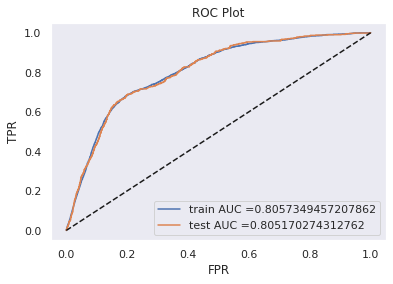

 The maximum value of tpr*(1-fpr) 0.5476140442707078 for threshold 0.526


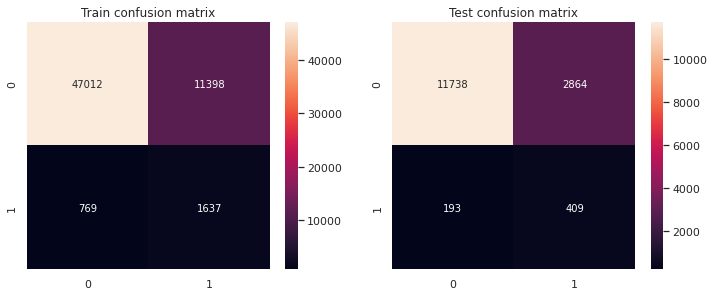

In [ ]:
model_lr1 = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 20}, max_iter = 1000)
model_lr1.fit(X_train1_ohe, y_train)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, model_lr1)

In [ ]:
y_test_final_pred = model_lr1.predict_proba(X_test1_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lr_1.csv", index=False)

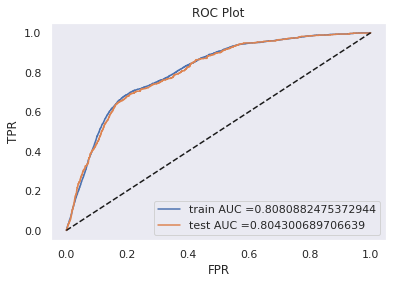

 The maximum value of tpr*(1-fpr) 0.5520405457849983 for threshold 0.513


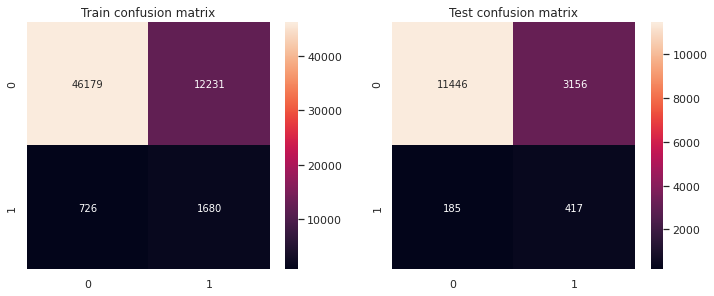

In [ ]:
model_lr2 = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 20}, max_iter = 1000)
model_lr2.fit(X_train2_ohe, y_train)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model_lr2)

In [ ]:
y_test_final_pred = model_lr2.predict_proba(X_test2_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lr_2.csv", index=False)

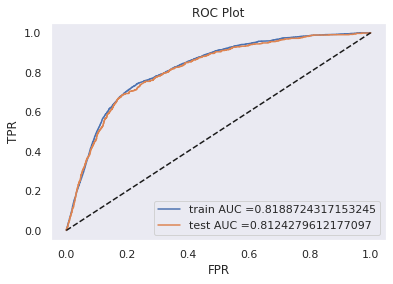

 The maximum value of tpr*(1-fpr) 0.5697785724583138 for threshold 0.49


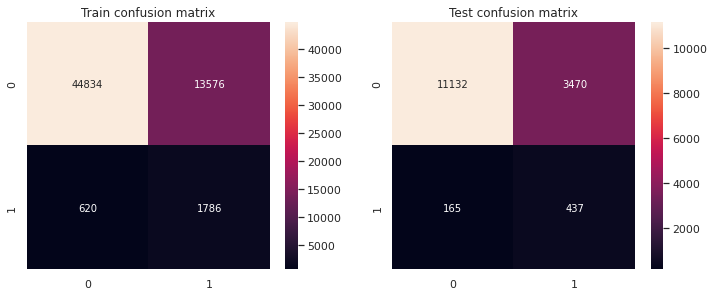

In [ ]:
model_lr3 = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 20}, max_iter = 1000)
model_lr3.fit(X_train3_ohe, y_train)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model_lr3)

In [ ]:
y_test_final_pred = model_lr3.predict_proba(X_test3_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lr_3.csv", index=False)

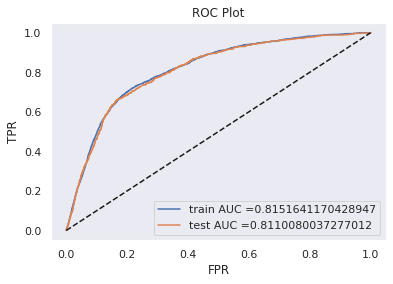

 The maximum value of tpr*(1-fpr) 0.5637038986736775 for threshold 0.496


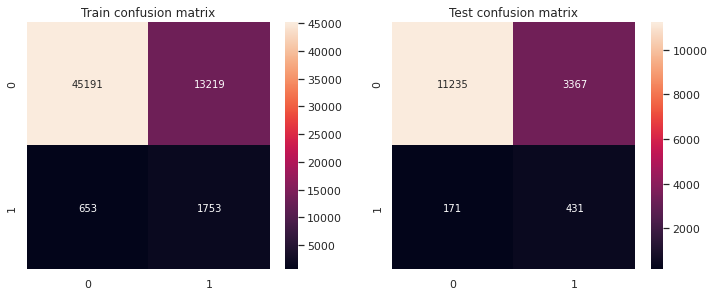

In [ ]:
model_lr4 = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 20}, max_iter = 1000)
model_lr4.fit(X_train1_re, y_train)
plotConfusionM(X_train1_re, X_test1_re, y_train, y_test, model_lr4)

In [ ]:
y_test_final_pred = model_lr4.predict_proba(X_test1_final_re)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lr_4.csv", index=False)

# 2. Grid Search Weighted Decision Tree

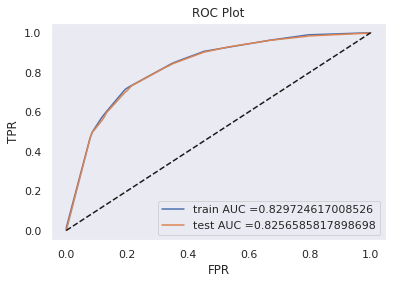

 The maximum value of tpr*(1-fpr) 0.5762817318969312 for threshold 0.161


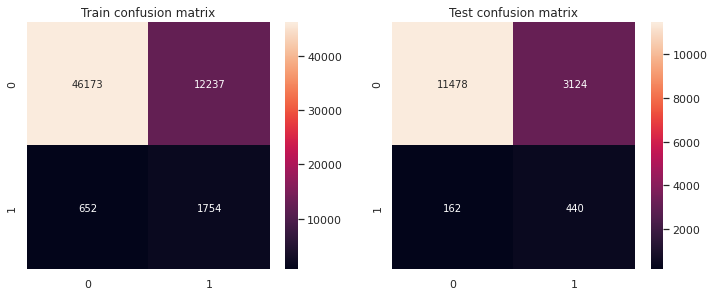

In [ ]:
model_dt1 = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=5)
model_dt1.fit(X_train1_ohe, y_train)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, model_dt1)

In [ ]:
y_test_final_pred = model_dt1.predict_proba(X_test1_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_dt_1.csv", index=False)

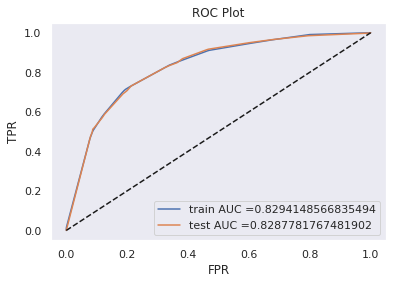

 The maximum value of tpr*(1-fpr) 0.5751169499637313 for threshold 0.161


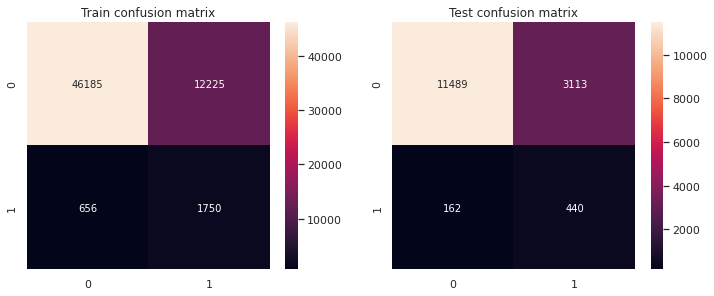

In [ ]:
model_dt2 = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=5)
model_dt2.fit(X_train2_ohe, y_train)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model_dt2)

In [ ]:
y_test_final_pred = model_dt2.predict_proba(X_test2_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_dt_2.csv", index=False)

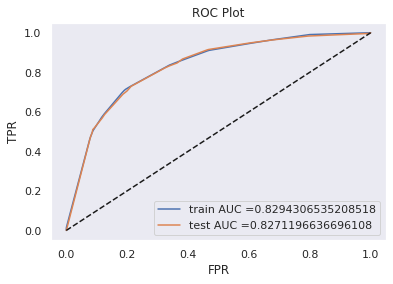

 The maximum value of tpr*(1-fpr) 0.5751294024255688 for threshold 0.161


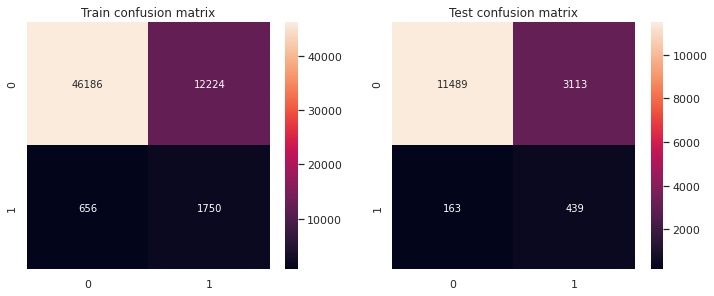

In [ ]:
model_dt3 = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=5)
model_dt3.fit(X_train3_ohe, y_train)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model_dt3)

In [ ]:
y_test_final_pred = model_dt3.predict_proba(X_test3_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_dt_3.csv", index=False)

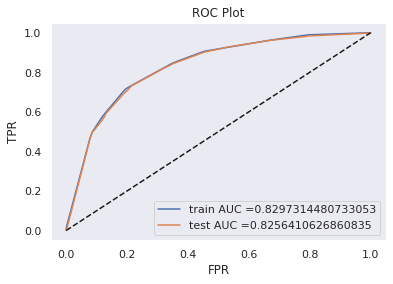

 The maximum value of tpr*(1-fpr) 0.5762942128215385 for threshold 0.161


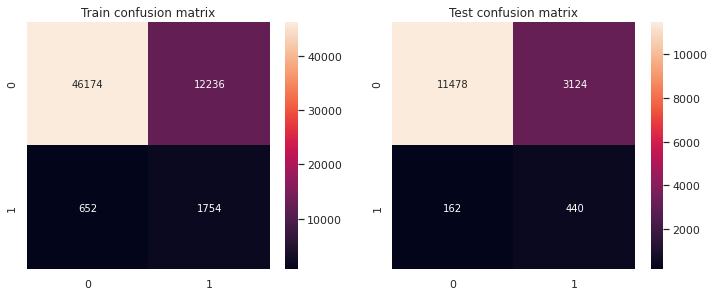

In [ ]:
model_dt4 = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=5)
model_dt4.fit(X_train1_re, y_train)
plotConfusionM(X_train1_re, X_test1_re, y_train, y_test, model_dt4)

In [ ]:
y_test_final_pred = model_dt4.predict_proba(X_test1_final_re)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_dt_4.csv", index=False)

# 3. Random Forest

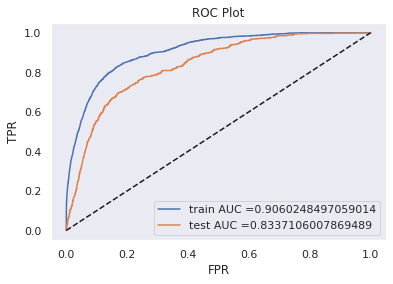

 The maximum value of tpr*(1-fpr) 0.690140553427252 for threshold 0.057


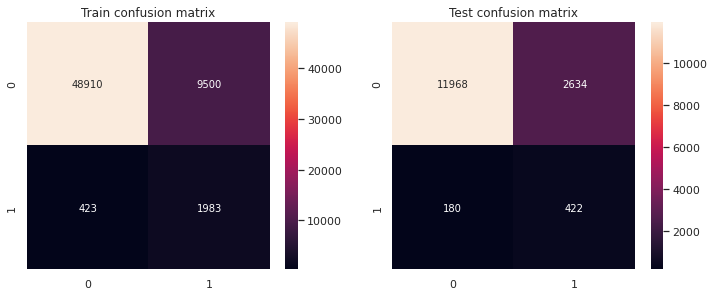

In [ ]:
model_rf1 = RandomForestClassifier(n_estimators= 150, max_depth= 13, min_samples_split= 5, min_samples_leaf= 2)
model_rf1.fit(X_train1_ohe, y_train)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, model_rf1)

In [ ]:
y_test_final_pred = model_rf1.predict_proba(X_test1_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_rf_1.csv", index=False)

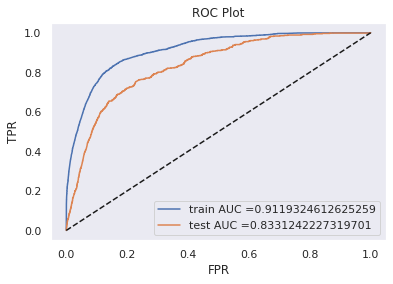

 The maximum value of tpr*(1-fpr) 0.7040123824434236 for threshold 0.059


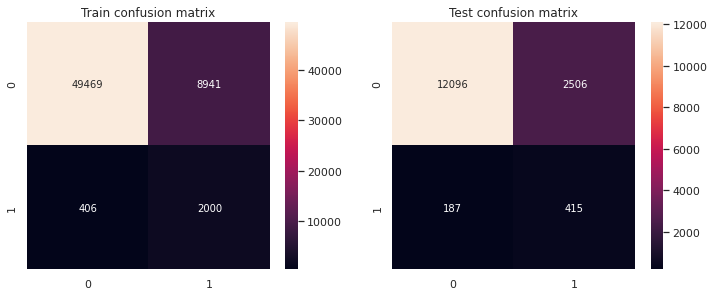

In [ ]:
model_rf2 = RandomForestClassifier(n_estimators= 150, max_depth= 13, min_samples_split= 5, min_samples_leaf= 2)
model_rf2.fit(X_train2_ohe, y_train)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model_rf2)

In [ ]:
y_test_final_pred = model_rf2.predict_proba(X_test2_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_rf_2.csv", index=False)

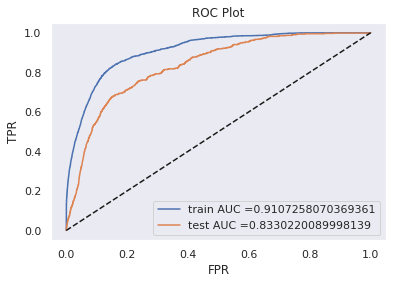

 The maximum value of tpr*(1-fpr) 0.704633425851567 for threshold 0.06


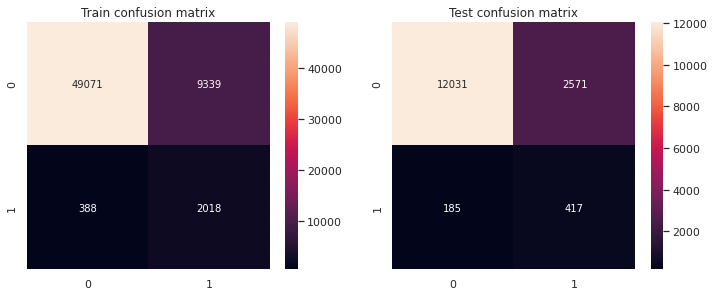

In [ ]:
model_rf3 = RandomForestClassifier(n_estimators= 150, max_depth= 13, min_samples_split= 5, min_samples_leaf= 2)
model_rf3.fit(X_train3_ohe, y_train)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model_rf3)

In [ ]:
y_test_final_pred = model_rf3.predict_proba(X_test3_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_rf_3.csv", index=False)

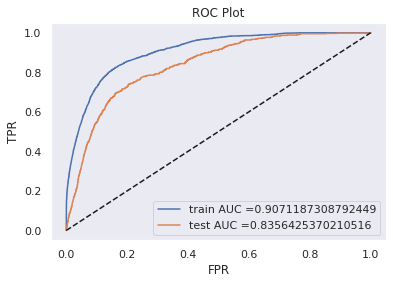

 The maximum value of tpr*(1-fpr) 0.691414404694763 for threshold 0.057


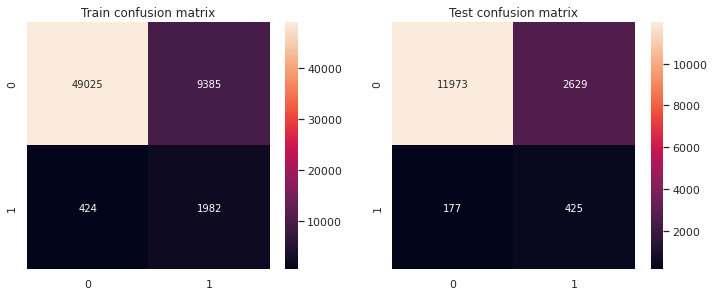

In [ ]:
model_rf4 = RandomForestClassifier(n_estimators= 150, max_depth= 13, min_samples_split= 5, min_samples_leaf= 2)
model_rf4.fit(X_train1_re, y_train)
plotConfusionM(X_train1_re, X_test1_re, y_train, y_test, model_rf4)

In [ ]:
y_test_final_pred = model_rf4.predict_proba(X_test1_final_re)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_rf_4.csv", index=False)

# 4. XGB Classifier

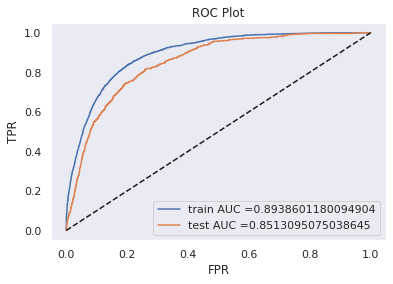

 The maximum value of tpr*(1-fpr) 0.6686786714091334 for threshold 0.043


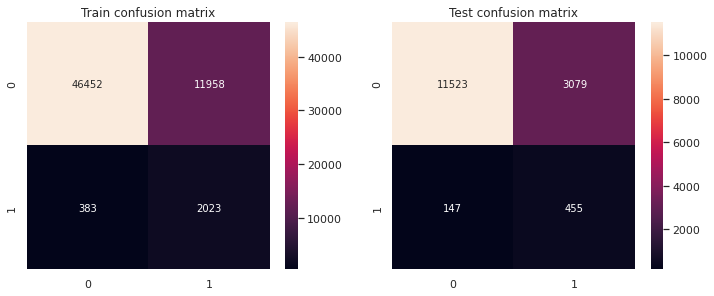

In [ ]:
import xgboost as xgb
model_xgb1 = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=665,
                      reg_alpha = 0.3,
                      max_depth=5
                     )
model_xgb1.fit(X_train1_ohe, y_train)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, model_xgb1)

In [ ]:
y_test_final_pred = model_xgb1.predict_proba(X_test1_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_xgb_1.csv", index=False)

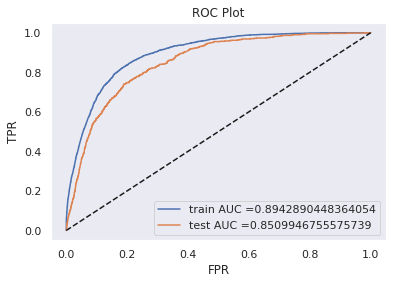

 The maximum value of tpr*(1-fpr) 0.671430053525662 for threshold 0.05


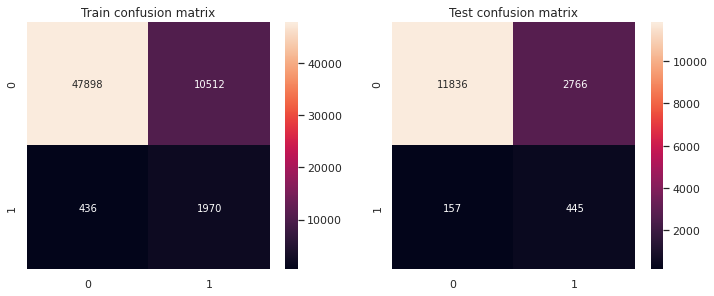

In [ ]:
import xgboost as xgb
model_xgb2 = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=665,
                      reg_alpha = 0.3,
                      max_depth=5
                     )
model_xgb2.fit(X_train2_ohe, y_train)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model_xgb2)

In [ ]:
y_test_final_pred = model_xgb2.predict_proba(X_test2_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_xgb_2.csv", index=False)

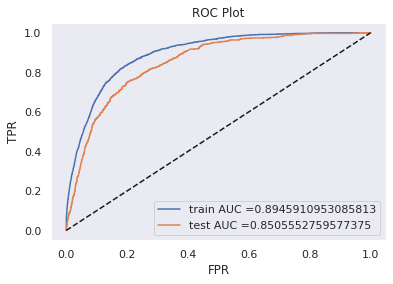

 The maximum value of tpr*(1-fpr) 0.6722551180685505 for threshold 0.051


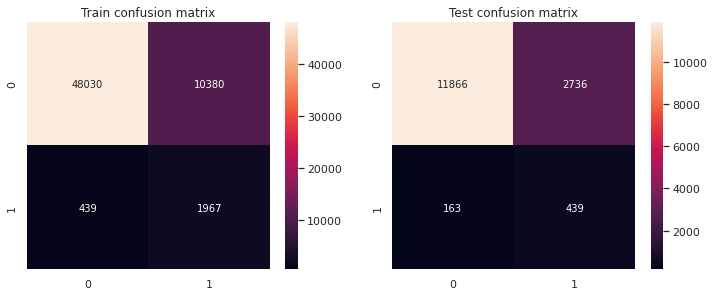

In [ ]:
import xgboost as xgb
model_xgb3 = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=665,
                      reg_alpha = 0.3,
                      max_depth=5
                     )
model_xgb3.fit(X_train3_ohe, y_train)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model_xgb3)

In [ ]:
y_test_final_pred = model_xgb3.predict_proba(X_test3_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_xgb_3.csv", index=False)

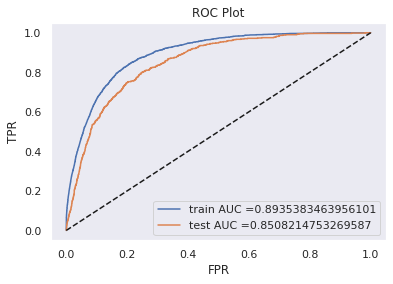

 The maximum value of tpr*(1-fpr) 0.6685640518346888 for threshold 0.047


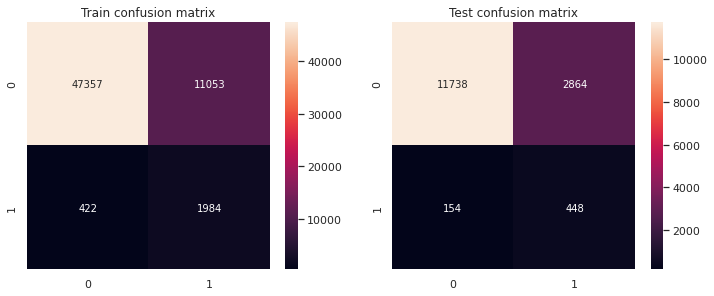

In [ ]:
import xgboost as xgb
model_xgb4 = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=665,
                      reg_alpha = 0.3,
                      max_depth=5
                     )
model_xgb4.fit(X_train1_re, y_train)
plotConfusionM(X_train1_re, X_test1_re, y_train, y_test, model_xgb4)

In [ ]:
y_test_final_pred = model_xgb4.predict_proba(X_test1_final_re)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_xgb_4.csv", index=False)

# 5.LightGBM Classifier

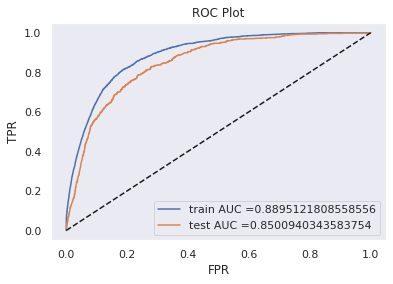

 The maximum value of tpr*(1-fpr) 0.6619532960101032 for threshold 0.048


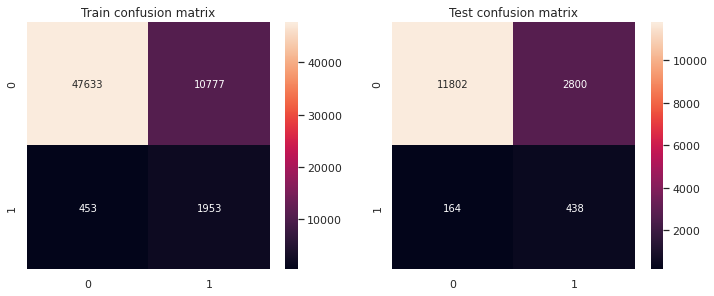

In [ ]:
import lightgbm as lgb
lgbm1 = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=250,
                      reg_alpha = 0.3,
                      max_depth=6
                     )
lgbm1.fit(X_train1_ohe, y_train)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, lgbm1)

In [ ]:
y_test_final_pred = lgbm1.predict_proba(X_test1_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lgbm_1.csv", index=False)

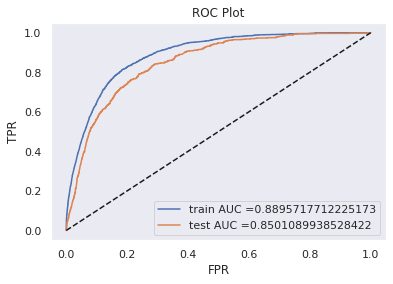

 The maximum value of tpr*(1-fpr) 0.664084524180048 for threshold 0.048


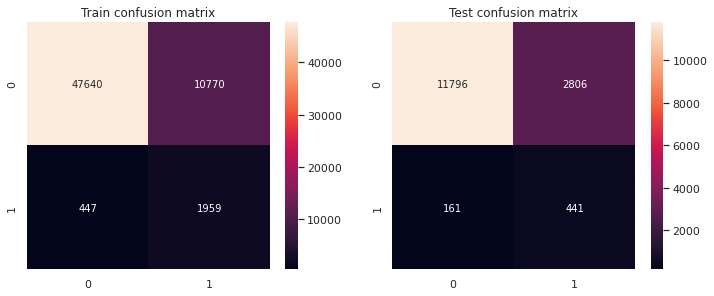

In [ ]:
import lightgbm as lgb
lgbm2 = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=250,
                      reg_alpha = 0.3,
                      max_depth=6
                     )
lgbm2.fit(X_train2_ohe, y_train)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, lgbm2)

In [ ]:
y_test_final_pred = lgbm2.predict_proba(X_test2_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lgbm_2.csv", index=False)

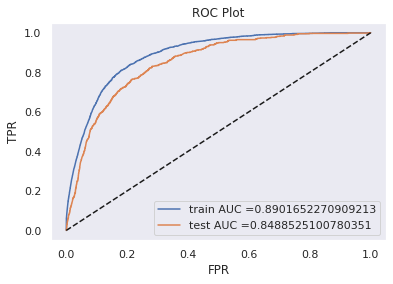

 The maximum value of tpr*(1-fpr) 0.663942551883716 for threshold 0.049


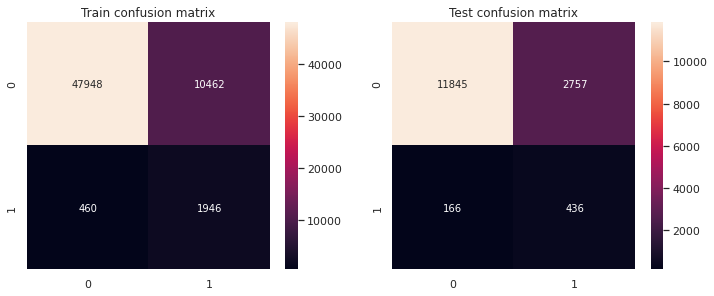

In [ ]:
import lightgbm as lgb
lgbm3 = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=250,
                      reg_alpha = 0.3,
                      max_depth=6
                     )
lgbm3.fit(X_train3_ohe, y_train)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, lgbm3)

In [ ]:
y_test_final_pred = lgbm3.predict_proba(X_test3_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lgbm_3.csv", index=False)

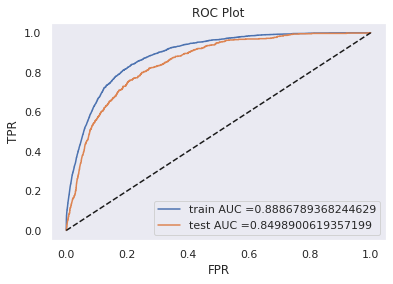

 The maximum value of tpr*(1-fpr) 0.6596308549518745 for threshold 0.04


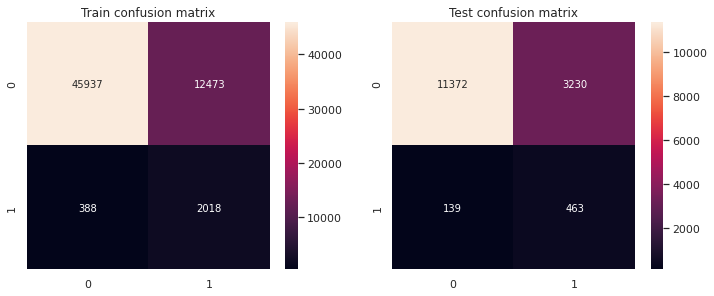

In [ ]:
import lightgbm as lgb
lgbm4 = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=250,
                      reg_alpha = 0.3,
                      max_depth=6
                     )
lgbm4.fit(X_train1_re, y_train)
plotConfusionM(X_train1_re, X_test1_re, y_train, y_test, lgbm4)

In [ ]:
y_test_final_pred = lgbm4.predict_proba(X_test1_final_re)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_lgbm_4.csv", index=False)

# 6. ADABoost

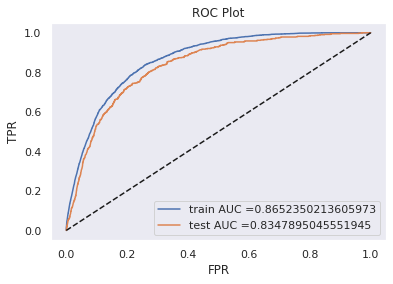

 The maximum value of tpr*(1-fpr) 0.6209464497177418 for threshold 0.498


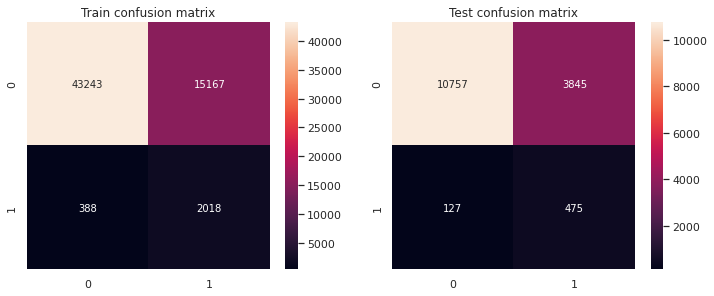

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb1 = AdaBoostClassifier(n_estimators=350, learning_rate=1, random_state=0)
clf_adb1.fit(X_train1_ohe, y_train)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, clf_adb1)

In [ ]:
y_test_final_pred = clf_adb1.predict_proba(X_test1_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_adb_1.csv", index=False)

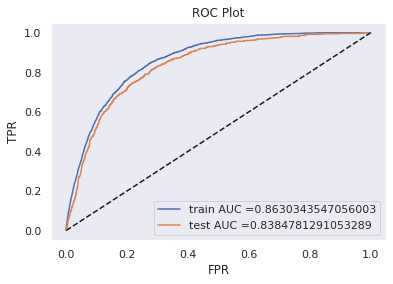

 The maximum value of tpr*(1-fpr) 0.6164781719729097 for threshold 0.498


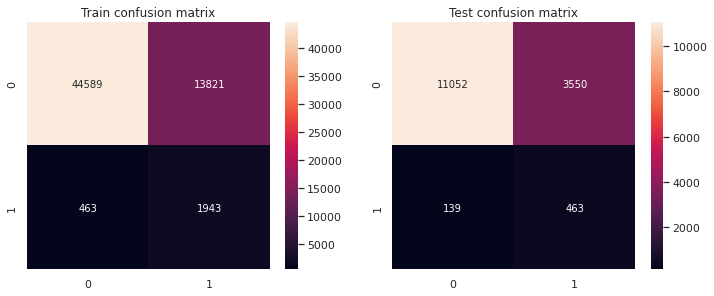

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb2 = AdaBoostClassifier(n_estimators=350, learning_rate=1, random_state=0)
clf_adb2.fit(X_train2_ohe, y_train)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, clf_adb2)

In [ ]:
y_test_final_pred = clf_adb2.predict_proba(X_test2_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_adb_2.csv", index=False)

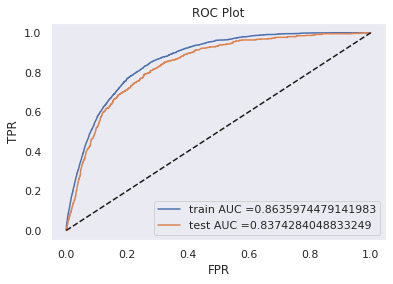

 The maximum value of tpr*(1-fpr) 0.6176421071387046 for threshold 0.498


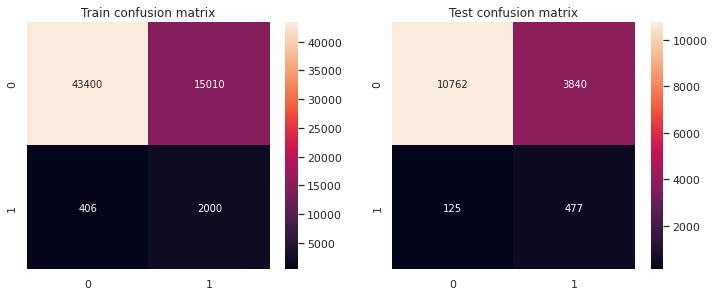

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb3 = AdaBoostClassifier(n_estimators=350, learning_rate=1, random_state=0)
clf_adb3.fit(X_train3_ohe, y_train)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, clf_adb3)

In [ ]:
y_test_final_pred = clf_adb3.predict_proba(X_test3_final_ohe)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_adb_3.csv", index=False)

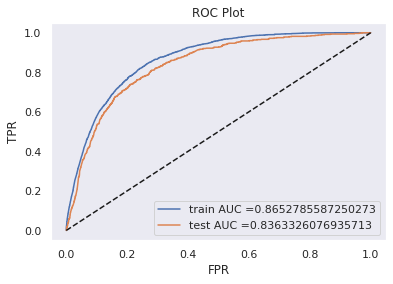

 The maximum value of tpr*(1-fpr) 0.6217291830060755 for threshold 0.498


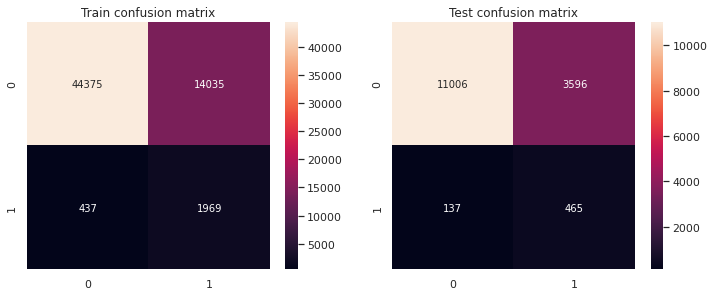

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb4 = AdaBoostClassifier(n_estimators=350, learning_rate=1, random_state=0)
clf_adb4.fit(X_train1_re, y_train)
plotConfusionM(X_train1_re, X_test1_re, y_train, y_test, clf_adb4)

In [ ]:
y_test_final_pred = clf_adb4.predict_proba(X_test1_final_re)[:,1]
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": y_test_final_pred})
submission.to_csv("submission_adb_4.csv", index=False)

In [ ]:
# save pickle
import pickle

with open('/content/drive/MyDrive/uoh_Project/models/model_lr1.pkl','wb') as w:
     pickle.dump(model_lr1, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_lr2.pkl','wb') as w:
     pickle.dump(model_lr2, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_lr3.pkl','wb') as w:
     pickle.dump(model_lr3, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_lr4.pkl','wb') as w:
     pickle.dump(model_lr4, w)

with open('/content/drive/MyDrive/uoh_Project/models/model_dt1.pkl','wb') as w:
     pickle.dump(model_dt1, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_dt2.pkl','wb') as w:
     pickle.dump(model_dt2, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_dt3.pkl','wb') as w:
     pickle.dump(model_dt3, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_dt4.pkl','wb') as w:
     pickle.dump(model_dt4, w)

with open('/content/drive/MyDrive/uoh_Project/models/model_rf1.pkl','wb') as w:
     pickle.dump(model_rf1, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_rf2.pkl','wb') as w:
     pickle.dump(model_rf2, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_rf3.pkl','wb') as w:
     pickle.dump(model_rf3, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_rf4.pkl','wb') as w:
     pickle.dump(model_rf4, w)

with open('/content/drive/MyDrive/uoh_Project/models/model_xgb1.pkl','wb') as w:
     pickle.dump(model_xgb1, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_xgb2.pkl','wb') as w:
     pickle.dump(model_xgb2, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_xgb3.pkl','wb') as w:
     pickle.dump(model_xgb3, w)
with open('/content/drive/MyDrive/uoh_Project/models/model_xgb.pkl','wb') as w:
     pickle.dump(model_xgb4, w)

with open('/content/drive/MyDrive/uoh_Project/models/lgbm1.pkl','wb') as w:
     pickle.dump(lgbm1, w)
with open('/content/drive/MyDrive/uoh_Project/models/lgbm2.pkl','wb') as w:
     pickle.dump(lgbm2, w)
with open('/content/drive/MyDrive/uoh_Project/models/lgbm3.pkl','wb') as w:
     pickle.dump(lgbm3, w)
with open('/content/drive/MyDrive/uoh_Project/models/lgbm4.pkl','wb') as w:
     pickle.dump(lgbm4, w)

with open('/content/drive/MyDrive/uoh_Project/models/clf_adb1.pkl','wb') as w:
     pickle.dump(clf_adb1, w)
with open('/content/drive/MyDrive/uoh_Project/models/clf_adb2.pkl','wb') as w:
     pickle.dump(clf_adb2, w)
with open('/content/drive/MyDrive/uoh_Project/models/clf_adb3.pkl','wb') as w:
     pickle.dump(clf_adb3, w)
with open('/content/drive/MyDrive/uoh_Project/models/clf_adb4.pkl','wb') as w:
     pickle.dump(clf_adb4, w)


# 7. Ensemble

In [18]:
import pickle
with open('/content/drive/MyDrive/uoh_Project/models/model_xgb.pkl', 'rb') as o: #random_forest
     model_xgb4 = pickle.load(o)
with open('/content/drive/MyDrive/uoh_Project/models/lgbm1.pkl', 'rb') as o: #random_forest
     lgbm1 = pickle.load(o)
with open('/content/drive/MyDrive/uoh_Project/models/model_xgb1.pkl', 'rb') as o: #random_forest
     model_xgb1 = pickle.load(o)
with open('/content/drive/MyDrive/uoh_Project/models/lgbm4.pkl', 'rb') as o: #random_forest
     lgbm4 = pickle.load(o)

In [20]:
final_y_test_pred1 = model_xgb4.predict_proba(X_test1_final_re)[:,1]
final_y_test_pred2 = lgbm1.predict_proba(X_test1_final_ohe)[:,1]
final_y_test_pred3 = model_xgb1.predict_proba(X_test1_final_ohe)[:,1]
final_y_test_pred4 = lgbm4.predict_proba(X_test1_final_re)[:,1]
final_y_test_pred1 = (final_y_test_pred1+final_y_test_pred2) / 4
submission = pd.DataFrame({"ID":test_data.ID, "TARGET": final_y_test_pred1})
submission.to_csv("submission_ensemble_1.csv", index=False)

In [31]:
def plot_feature_importance(df,feat_imp,label,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat,color='#69b3a2') #plotting feature importance 
    plt.title('Feature Importance '+label)
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [25]:
X_train1_re = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train1_re.pkl")
X_test1_re = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test1_re.pkl")
X_test1_final_re = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test1_final_re.pkl")

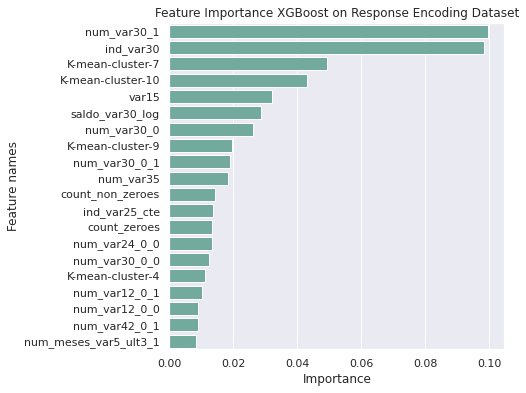

In [32]:
plot_feature_importance(X_train1_re, model_xgb4.feature_importances_,"XGBoost on Response Encoding Dataset")

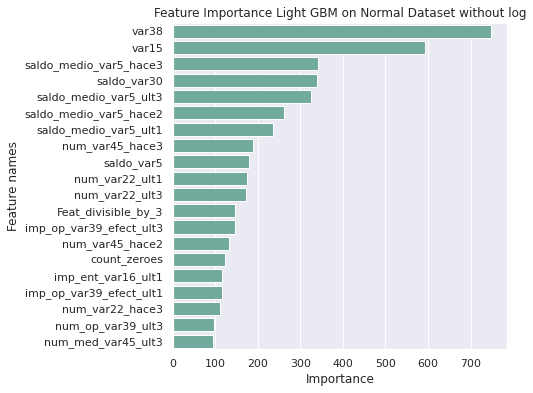

In [34]:
plot_feature_importance(X_train1_ohe, lgbm1.feature_importances_,"Light GBM on Normal Dataset without log")

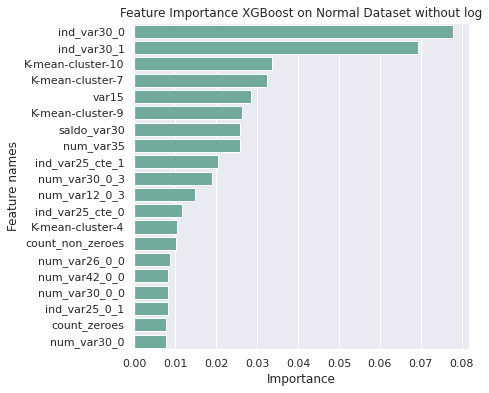

In [35]:
plot_feature_importance(X_train1_ohe, model_xgb1.feature_importances_,"XGBoost on Normal Dataset without log")

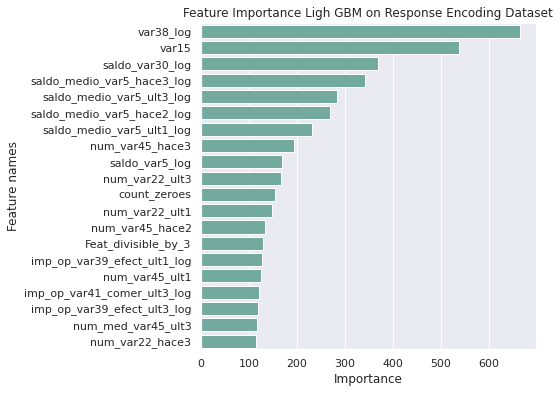

In [36]:
plot_feature_importance(X_train1_re, lgbm4.feature_importances_,"Ligh GBM on Response Encoding Dataset")

In [ ]:
#final_y_test_pred_lr1 = model_lr1.predict_proba(X_test1_final_ohe)[:,1]
#final_y_test_pred_dt1 = model_dt1.predict_proba(X_test1_final_ohe)[:,1]
final_y_test_pred_rf1 = model_rf1.predict_proba(X_test1_final_ohe)[:,1]
final_y_test_pred_xgb1 = model_xgb1.predict_proba(X_test1_final_ohe)[:,1]
final_y_test_pred_lgbm1 = lgbm1.predict_proba(X_test1_final_ohe)[:,1]
final_y_test_pred_abd1 = clf_adb1.predict_proba(X_test1_final_ohe) [:,1]

final_y_test_pred1= (#final_y_test_pred_lr1+
                     #final_y_test_pred_dt1+ 
                     final_y_test_pred_rf1+ 
                     final_y_test_pred_xgb1+ 
                     final_y_test_pred_lgbm1+
                     final_y_test_pred_abd1)/4

submission = pd.DataFrame({"ID":test_data.ID, "TARGET": final_y_test_pred1})
submission.to_csv("submission_ensemble1.csv", index=False)

In [ ]:
#final_y_test_pred_lr2 = model_lr2.predict_proba(X_test1_final_ohe)[:,1]
#final_y_test_pred_dt2 = model_dt2.predict_proba(X_test1_final_ohe)[:,1]
final_y_test_pred_rf2 = model_rf2.predict_proba(X_test2_final_ohe)[:,1]
final_y_test_pred_xgb2 = model_xgb2.predict_proba(X_test2_final_ohe)[:,1]
final_y_test_pred_lgbm2 = lgbm2.predict_proba(X_test2_final_ohe)[:,1]
final_y_test_pred_abd2 = clf_adb2.predict_proba(X_test2_final_ohe) [:,1]

final_y_test_pred2= (#final_y_test_pred_lr2+
                     #final_y_test_pred_dt2+ 
                     final_y_test_pred_rf2+ 
                     final_y_test_pred_xgb2+ 
                     final_y_test_pred_lgbm2+
                     final_y_test_pred_abd2)/4

submission = pd.DataFrame({"ID":test_data.ID, "TARGET": final_y_test_pred2})
submission.to_csv("submission_ensemble2.csv", index=False)

In [ ]:
#final_y_test_pred_lr3 = model_lr3.predict_proba(X_test3_final_ohe)[:,1]
#final_y_test_pred_dt3 = model_dt3.predict_proba(X_test3_final_ohe)[:,1]
final_y_test_pred_rf3 = model_rf3.predict_proba(X_test3_final_ohe)[:,1]
final_y_test_pred_xgb3 = model_xgb3.predict_proba(X_test3_final_ohe)[:,1]
final_y_test_pred_lgbm3 = lgbm3.predict_proba(X_test3_final_ohe)[:,1]
final_y_test_pred_abd3 = clf_adb3.predict_proba(X_test3_final_ohe) [:,1]

final_y_test_pred3= (#final_y_test_pred_lr3+
                     #final_y_test_pred_dt3+ 
                     final_y_test_pred_rf3+ 
                     final_y_test_pred_xgb3+ 
                     final_y_test_pred_lgbm3+
                     final_y_test_pred_abd3)/4

submission = pd.DataFrame({"ID":test_data.ID, "TARGET": final_y_test_pred3})
submission.to_csv("submission_ensemble3.csv", index=False)

In [ ]:
#final_y_test_pred_lr4 = model_lr4.predict_proba(X_test1_final_re)[:,1]
#final_y_test_pred_dt4 = model_dt4.predict_proba(X_test1_final_re)[:,1]
final_y_test_pred_rf4 = model_rf4.predict_proba(X_test1_final_re)[:,1]
final_y_test_pred_xgb4 = model_xgb4.predict_proba(X_test1_final_re)[:,1]
final_y_test_pred_lgbm4 = lgbm4.predict_proba(X_test1_final_re)[:,1]
final_y_test_pred_abd4 = clf_adb4.predict_proba(X_test1_final_re) [:,1]

final_y_test_pred4= (#final_y_test_pred_lr4+
                     #final_y_test_pred_dt4+ 
                     final_y_test_pred_rf4+ 
                     final_y_test_pred_xgb4+ 
                     final_y_test_pred_lgbm4+
                     final_y_test_pred_abd4)/4

submission = pd.DataFrame({"ID":test_data.ID, "TARGET": final_y_test_pred4})
submission.to_csv("submission_ensemble4.csv", index=False)